In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import multivariate_normal, norm

%matplotlib inline

# Fix the random seed for replicability.
np.random.seed(12345678)

from matplotlib import animation
import matplotlib
# matplotlib.rc('animation', html='html5')

from ipywidgets import interact, interactive, widgets
from IPython.display import display, HTML

from pymc3.stats import autocorr

For the following examples, we aim to use MCMC methods to sample from a bivariate normal distribution, i.e.:

$$
p(\mathbf{x}) = \mathcal{N}(\mu, \mathbf{\Sigma})
$$

with mean $\mu = (0, 0)$, and covariance matrix:

$$
\mathbf{\Sigma} = \begin{bmatrix}
1 & 0.8 \\
0.8 & 1
\end{bmatrix}
$$

In [7]:
# Define the distributions
p = multivariate_normal([0.0, 0.0], [[1.0, 0.8], [0.8, 1.0]])

# Fixed number of samples
samples = 1000

# Fix lag time to calculate ACF
max_lags = 20

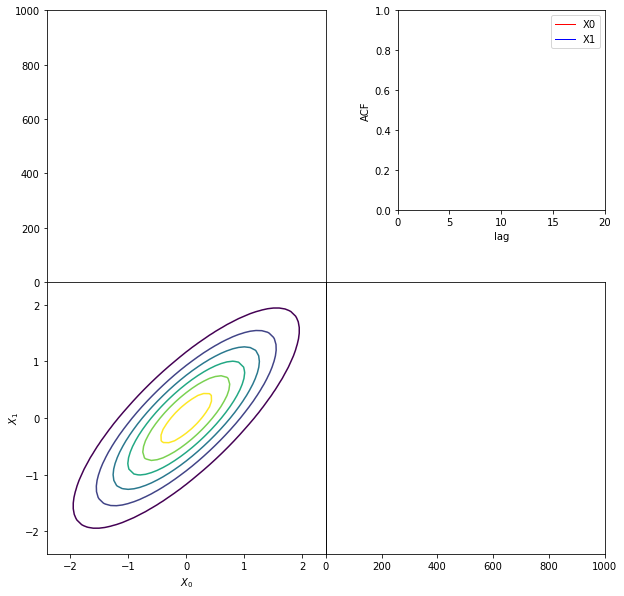

In [8]:
# Generate data and plot contour
xlim = [-2.4, 2.4]
ylim = [-2.4, 2.4]
x = np.arange(xlim[0], xlim[1], 0.1)
y = np.arange(ylim[0], ylim[1], 0.1)

# Quickly hacked plotting code
fig = plt.figure(figsize=(10, 10))
i_width = (xlim[0], xlim[1])
s_width = (ylim[0], ylim[1])
samples_width = (0, samples)

# Plot the subplots
ax1 = fig.add_subplot(221, xlim=i_width, ylim=samples_width)
ax2 = fig.add_subplot(224, xlim=samples_width, ylim=s_width)
ax3 = fig.add_subplot(223, xlim=i_width, ylim=s_width,
                      xlabel=r'$X_0$',
                      ylabel=r'$X_1$')
ax4 = fig.add_subplot(222, xlim=[0, max_lags], ylim=[0.0, 1.0],
                     xlabel='lag',
                     ylabel='ACF')
fig.subplots_adjust(wspace=0.0, hspace=0.0)

# Change a bit on subplot 4, wacky hacky
pos1 = ax4.get_position() # get the original position 
pos2 = [pos1.x0 + 0.1, pos1.y0 + 0.1,  pos1.width - 0.1, pos1.height - 0.1]
ax4.set_position(pos2) # set a new position

# Add the contour
X, Y = np.meshgrid(x, y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
CS = ax3.contour(X, Y, p.pdf(pos))

# Add the lines
line1, = ax1.plot([], [], lw=1) # Top plot for X0
line2, = ax2.plot([], [], lw=1) # Right blot for X1
line3, = ax3.plot([], [], 'o', lw=2, alpha=.1) # The dots on the contour
line4, = ax3.plot([], [], lw=1, alpha=.3) # The path on the contour
line5, = ax3.plot([], [], 'k', lw=1) # The vertical line from the contour to the top
line6, = ax3.plot([], [], 'k', lw=1) # The horizontal line from the contour to the right
line7, = ax4.plot([], [], 'r', lw=1, label='X0') # ACF for X0
line8, = ax4.plot([], [], 'b', lw=1, label='X1') # ACF for X1
ax4.legend(loc="upper right")
ax1.set_xticklabels([]) # Remove x label
ax2.set_yticklabels([]) # Remove y label
lines = [line1, line2, line3, line4, line5, line6]

In [9]:
def init():
    for line in lines:
        line.set_data([], [])
    return lines

def animate(i, Z, max_lags):
    line1.set_data(Z[:i,0][::-1], range(len(Z[:i,0])))
    line2.set_data(range(len(Z[:i,1])), Z[:i,1][::-1])
    line3.set_data(Z[:i,0], Z[:i,1])
    line4.set_data(Z[:i,0], Z[:i,1])
    line5.set_data([Z[i-1,0], Z[i-1,0]], [Z[i-1,1], s_width[1]])
    line6.set_data([Z[i-1,0], i_width[1]], [Z[i-1,1], Z[i-1,1]])
    
    # Calculate the ACF and plot on graph after some samples
    if i >= 20:
        lags = np.arange(1, max_lags)
        line7.set_data(lags, [autocorr(Z[:i,0], l) for l in lags])
        line8.set_data(lags, [autocorr(Z[:i,1], l) for l in lags])
        
    return lines

# Metropolis-Hastings Samplings

The first approach for performing multidimensional sampling is to use *block-wise updates*. In this approach the proposal distribution $q(\mathbf{x})$ has the same dimensionality as the target distribution $p(\mathbf{x})$. We the accept the proposed state $\mathbf{x}^{*}$ from the proposed distribution $q(\mathbf{x})$ using the Metropolis-Hastings algorithms.

1. Set $t = 0$.
1. Generate an initial state $\mathbf{x}_0 \sim \pi_0$.
1. While $t < N$ where $N$ is the desired number of samples:
    1. $t = t+1$
    1. Generate a proposal state $\mathbf{x}^{*} \sim q(\mathbf{x}|\mathbf{x}^{t-1})$
    1. Calculate the proposal correction factor: $c = \frac{ q(\mathbf{x}^{t-1}|\mathbf{x}^{*})    }{q(\mathbf{x}^{*}|\mathbf{x}^{t-1}) }$
    1. Calculate the acceptance probability $\alpha = \min(1, \frac{p(\mathbf{x}^{*})}{p(\mathbf{x}^{t-1})} \times c)$
    1. Draw a random number $u \sim Uni(0, 1)$
    1. If $u \leq \alpha$ then accept the proposal, $\mathbf{x}^t = \mathbf{x}^{*}$.
    1. Else, reject the proposal, $\mathbf{x}^{t} = \mathbf{x}^{t-1}$.
    
For our proposal distribution in this code, $q(\mathbf{x})$, we use a circular normal distribution centered at the previous state of the Markov chain, i.e.:
$$
q(\mathbf{x}|\mathbf{x}^{t-1}) \sim \mathcal{N} (\mathbf{x}_{t-1}, \mathbf{I})
$$

In [10]:
'''
Metropolis-Hastings Sampling
'''
# Initilise value 
x = np.random.uniform(0.0, 1.0, size=2)

# Generate the 2D matrix
Z = np.zeros((samples+1, 2))
Z[0,:] = x

# Run Metropolis Sampling
t = 0
while t < samples:
    # Increase iteration
    t = t+1
    
    # Generate proposal distribution and take a sample
    q = multivariate_normal(x, [[1.0, 0.0], [0.0, 1.0]])
    xstar = q.rvs()
    
    # Calculate correction factor
    qstar = multivariate_normal(xstar, [[1.0, 0.0], [0.0, 1.0]])
    qprev = multivariate_normal(x, [[1.0, 0.0], [0.0, 1.0]])
    c = qstar.pdf(x)/qprev.pdf(xstar)
    
    # Calculate the acceptance probability
    alpha = min(1.0, (p.pdf(xstar)/p.pdf(x))*c)
    
    # Draw the uniform and check for acceptance/rejection
    u = np.random.uniform(0.0, 1.0, size=1)
    if u<=alpha:
        x = xstar
        Z[t,:] = x
    else:
        Z[t,:] = x

In [11]:
anim = animation.FuncAnimation(fig, animate, init_func=init, fargs=(Z, max_lags),
                               frames=samples, interval=50, blit=True)

HTML(anim.to_html5_video())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


# Component-wise Metropolis-Hastings Samplings

A problem with block-wise updates is that finding a suitable proposal distribution is difficult (i.e. when the dimension gets large). This leads to a large proportion of the samples being rejected. One way to remedy this is to simply loop over the dimension of $\mathbf{x}$, sampling each diemsnion independently from the others. This is known as using *component-wise updates*.

A key difference is that the proposal distribution $q(x)$ is univariate, working only in one dimension (which is great cause we have several 1D distribution to play around with!). The algorithm is as follwed. 

1. Set $t = 0$.
1. Generate an initial state $\mathbf{x}_0 \sim \pi_0$.
1. While $t < N$ where $N$ is the desired number of samples:
    1. $t = t+1$
    1. For each dimension $i$:
        1. Generate a proposal state $x_i^{*} \sim q(x_i|x^{t-1}_i)$
        1. Calculate the proposal correction factor: $c = \frac{ q(x_i^{t-1}|x_i^{*}) }{ q(x_i^{*}|x_i^{t-1}) }$
        1. Calculate the acceptance probability $\alpha = \min(1, \frac{p(\mathbf{x}_{-i}, x^{*}_i)}{p(\mathbf{x}_{-i}^{t-1}, x_i)} \times c)$
        1. Draw a random number $u \sim Uni(0, 1)$
        1. If $u \leq \alpha$ then accept the proposal, $x^t_i = x^{*}_i$.
        1. Else, reject the proposal, $\mathbf{x}^{t} = \mathbf{x}^{t-1}$.
    
Note that in the component-wise implementation, a sample for the $i$-th dimension is proposed, then accepted or rejected while all other dimensions are being fixed. We then move on to the next dimension and repeat the process. In each successive step we are using updated values for the dimensions that have occurred over one iteration, i.e. from $(t-1) \rightarrow t$.

For the proposal distribution, $q(x)$ is now a univariate normal distribution with unit variance in the direction of the dimension to be sampled. 

In [ ]:
'''
Component-wise Metropolis-Hastings Sampling
'''
# Initilise value 
x = np.random.uniform(0.0, 1.0, size=2)

# Generate the 2D matrix
Zc = np.zeros((samples+1, 2))
Zc[0,:] = x

# Run Component-wise Metropolis Sampling
t = 0
while t < samples:
    # Increase iteration
    t = t+1
    
    # Loop over dimension
    for i in range(len(x)):
        # Copy xstar
        xstar = x.copy()
        
        # Generate proposal distribution and take a sample
        qc = norm(loc=x[i], scale=1.0)
        xs = qc.rvs()
    
        # Calculate correction factor
        qs = norm(loc=xs, scale=1.0)
        qp = norm(loc=x[i], scale=1.0)
        c = qs.pdf(x[i])/qp.pdf(xs)
        # The calculation here is included for the sake of completeness
        # In fact, N(x, 1) is symmetric, hence c=1 all the time
        
        # Replace the dimension to create the proposal
        xstar[i] = xs
    
        # Calculate the acceptance probability
        alpha = min(1.0, (p.pdf(xstar)/p.pdf(x))*c)
    
        # Draw the uniform and check for acceptance/rejection
        u = np.random.uniform(0.0, 1.0, size=1)
        if u<=alpha:
            x[i] = xstar[i]
    
    # Record the value
    Zc[t,:] = x

In [ ]:
anim = animation.FuncAnimation(fig, animate, init_func=init, fargs=(Zc,),
                               frames=samples, interval=20, blit=True)

HTML(anim.to_html5_video())

# The Gibbs Sampler

Component-wise updates for MCMC algorithms are generally more efficient for multivariate problems than blockwise updates in that we are more likely to accept a proposed sample by drawing each component/dimension indenpendently of the others. However, samples may still be rejected, leading to excess computation that is never used. The Gibbs sampler provides a means of avoiding such wasted computation. All proposed samples are accepted in Gibbs sampler so there is no wasted computation. 

The Gibbs sampler works in the same way as component-wise Metropolis-Hastings algorithms, except instead of drawing from the proposal distribution for each dimension, then accepting or rejecting the proposed sample, we simple draw a value for that dimension according to the variable's corresponding conditional distribution. We also accept all values that are drawn. There are two requirements:

1. We need the mathematical expression for the conditional distribution of each variable, i.e. $p(x_i|x_j) \forall i \neq j$. And hence,
1. We need to be able to sample from each conditional distribution.

The algorithm is as follwed.

1. Set $t = 0$.
1. Generate an initial state $\mathbf{x}_0 \sim \pi_0$.
1. While $t < N$ where $N$ is the desired number of samples:
    1. $t = t+1$
    1. For each dimension $i$:
        1. Draw $x_i$ from $p(x_i|x_{-i})$.
    
Note that in the component-wise implementation, a sample for the $i$-th dimension is proposed, then accepted or rejected while all other dimensions are being fixed. We then move on to the next dimension and repeat the process. In each successive step we are using updated values for the dimensions that have occurred over one iteration, i.e. from $(t-1) \rightarrow t$.

Using our current example, the conditional for the first dimension
$$
p(x_1|x_2^{t-1}) = \mathcal{N} \left( \mu_1 + \sigma_{21} \left( x_2^{t-1} - \mu_2 \right), \sqrt{1 - \sigma_{21}^2} \right)
$$
and for the second one:
$$
p(x_2|x_1^{t}) = \mathcal{N} \left( \mu_2 + \sigma_{12} \left( x_1^{t} - \mu_1 \right), \sqrt{1 - \sigma_{12}^2} \right)
$$

They are both univariate normal distributions, each with a mean that is dependent on the value of the most recent state of the conditioning vairable, and a variance that is dependent on the target covariances between the two variables. 

In [ ]:
'''
The Gibbs Sampler
'''
# Generate the 2D matrix
Zg = np.zeros((samples+1, 2))
Zg[0,:] = np.random.uniform(0.0, 1.0, size=2)

# Mean and covariance
mu = [0.0, 0.0]
cov = [0.8, 0.8] # 12 and 21

# Run Gibbs Sampler
t = 0
while t < samples:
    # Increase iteration
    t = t+1
    
    # Draw the first dimension
    Zg[t,0] = np.random.normal( mu[0] + cov[1]*(Zg[t-1,1] - mu[1]), np.sqrt(1 - cov[1]**2))
    
    # Then the second
    Zg[t,1] = np.random.normal( mu[1] + cov[0]*(Zg[t,0] - mu[0]), np.sqrt(1 - cov[0]**2))

In [ ]:
anim = animation.FuncAnimation(fig, animate, init_func=init, fargs=(Zg,),
                               frames=samples, interval=20, blit=True)

HTML(anim.to_html5_video())